In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
from PIL import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import backend as K
from pyimagesearch.new_convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

In [2]:
# Define the visualization function for reconstructed images
def visualize_predictions(decoded, gt, samples=10):
    # Initialize the list of output images
    outputs = None
    for i in range(0, samples):
        # Grab the original image and reconstructed image
        original = (gt[i] * 255).astype("uint8")
        recon = (decoded[i] * 255).astype("uint8")
        # Stack them side by side
        output = np.hstack([original, recon])
        if outputs is None:
            outputs = output
        else:
            outputs = np.vstack([outputs, output])
    return outputs

In [3]:
# Hardcoded values
# EPOCHS = 10
# INIT_LR = 1e-3
# BS = 16
# IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH = 128, 128, 3  # Change to 128x128 RGB images
# MODEL_SAVE_PATH = "autoencoder_model.h5"
# VIS_PATH = "data/recon_vis2.png"
# PLOT_PATH = "data/plot2.png"
# save_dir = "data"

MODEL_PATH = "autoencoder_model.keras"
VISUALIZATION_PATH = "data/images/reconstruction_visualization.png"
PLOT_PATH = "data/images/training_plot.png"

EPOCHS = 10
INIT_LR = 1e-3
BATCH_SIZE = 16
IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH = 128, 128, 3  # Change to 128x128 RGB images

In [4]:
train_data_csv = pd.read_csv("data/train_data.csv")
validation_data_csv = pd.read_csv("data/validation_data.csv")

In [5]:
num_images = len(validation_data_csv)
image_shape = (128, 128, 3)

validation_data = np.empty((num_images, *image_shape), dtype=np.uint8)

for i in range(num_images):
    image_path = validation_data_csv.iloc[i]['cutOutImages_path']
    
    # Open image and resize to (32, 32)
    # img = Image.open(image_path).resize((32, 32))  # Resize to uniform shape
    img = Image.open(image_path).resize((128, 128), Image.Resampling.BILINEAR)
    # If the image is grayscale (L mode), convert it to RGB
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # Ensure it's in the desired shape (32, 32, 3)
    if img_array.shape != image_shape:
        raise ValueError(f"Image at {image_path} has shape {img_array.shape}, expected {image_shape}")

    # Add to pre-allocated array
    validation_data[i] = img_array

print(validation_data.shape)  # (50000, 32, 32, 3)

(6500, 128, 128, 3)


In [6]:
# Preallocate array
num_images = len(train_data_csv)
train_data = np.empty((num_images, *image_shape), dtype=np.uint8)

valid_image_count = 0  # Counter for valid images

for i in range(num_images):
    image_path = train_data_csv.iloc[i]['cutOutImages_path']
    
    try:
        # Open image, resize, and convert to RGB
        img = Image.open(image_path).resize((128, 128), Image.Resampling.BILINEAR).convert('RGB')
        img_array = np.array(img)
        
        # Validate shape
        if img_array.shape != image_shape:
            print(f"Skipping {image_path}: shape {img_array.shape} is invalid.")
            continue
        
        # Add to pre-allocated array
        train_data[valid_image_count] = img_array
        valid_image_count += 1
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        continue

# Resize train_data to fit only valid images
train_data = train_data[:valid_image_count]

print(f"Final shape: {train_data.shape}")

Final shape: (25000, 128, 128, 3)


In [7]:
X_train = np.reshape(train_data, (len(train_data), 128, 128, 3)) / 255.
X_test = np.reshape(validation_data, (len(validation_data), 128, 128, 3)) / 255.

In [8]:
# lr_schedule = ExponentialDecay(
#     initial_learning_rate=INIT_LR, 
#     decay_steps=100000, 
#     decay_rate=0.96, 
#     staircase=True
# )

# checkpoint = ModelCheckpoint(
#         filepath=os.path.join(save_dir, "best_model_1.keras"),  # Use `.keras` extension
#         monitor="val_loss",
#         save_best_only=True,
#         mode="min",
#         verbose=1
#     )

# early_stopping = EarlyStopping(
#         monitor="val_loss",
#         patience=3,  # Stop if no improvement after 10 epochs
#         verbose=1,
#         restore_best_weights=True
#     )

In [9]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor="val_loss", verbose=1),
    CSVLogger("training_log.csv", append=False)
]

lr_schedule = ExponentialDecay(
    initial_learning_rate=INIT_LR, 
    decay_steps=100000, 
    decay_rate=0.96, 
    staircase=True
)

In [10]:
print(1)

1


In [11]:
print(1)

1


In [12]:
print("[INFO] building autoencoder...")
# autoencoder = ConvAutoencoder.build(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, filters=(16, 32, 64, 64, 128, 128, 256, 512), latentDim=512)
autoencoder = ConvAutoencoder.build(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, filters=(32,32,32,64,64,64,128), latent_dim=512)
opt = Adam(learning_rate=lr_schedule)
autoencoder.compile(
    loss=MeanSquaredError(),   # Use MeanSquaredError explicitly 
    metrics=[Accuracy()],      # Explicitly use Accuracy metric if needed
    optimizer=opt
)

[INFO] building autoencoder...
Printing filters : (32, 32, 32, 64, 64, 64, 128)
Printing latent dim  : 512


In [13]:
# Train the autoencoder
print("[INFO] training autoencoder...")
H = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

[INFO] training autoencoder...
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 1.4127e-05 - loss: 0.0464
Epoch 1: val_loss improved from inf to 0.02686, saving model to autoencoder_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 271s 171ms/step - accuracy: 1.4129e-05 - loss: 0.0464 - val_accuracy: 3.9341e-05 - val_loss: 0.0269
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 1.8506e-05 - loss: 0.0221
Epoch 2: val_loss improved from 0.02686 to 0.01871, saving model to autoencoder_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 258s 165ms/step - accuracy: 1.8513e-05 - loss: 0.0221 - val_accuracy: 2.5485e-05 - val_loss: 0.0187
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 4.0028e-05 - loss: 0.0177
Epoch 3: val_loss improved from 0.01871 to 0.01555, saving model to autoencoder_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 259s 166ms/step - accuracy: 4.0052e-05 - loss: 0.0177 - val_accuracy: 1.6369e-04 - val_loss: 0.0155
Epoch 4/10
1563/1563 ━

In [14]:
print(1)

1


[INFO] making predictions...
204/204 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step
[INFO] Plotting training history...


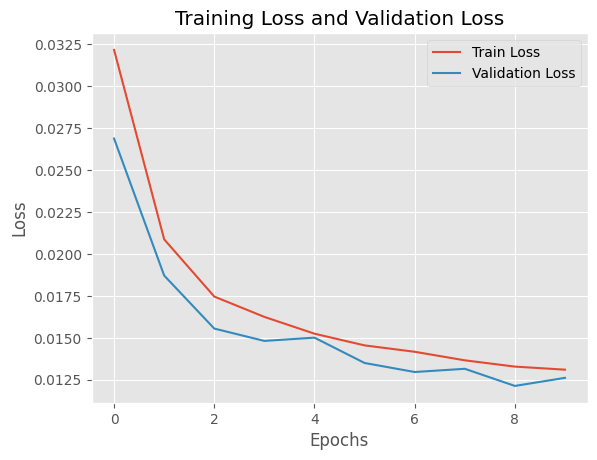

[INFO] Model saved to autoencoder_model.keras
[INFO] Reconstruction visualization saved to data/images/reconstruction_visualization.png
[INFO] Training plot saved to data/images/training_plot.png


In [15]:
# Use the trained autoencoder to make predictions on the test set
print("[INFO] making predictions...")
decoded = autoencoder.predict(X_test)

# Visualize the predictions and save the results
vis = visualize_predictions(decoded, X_test)
cv2.imwrite(VISUALIZATION_PATH, vis)

# Plot and save the training history
print("[INFO] Plotting training history...")
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="Train Loss")
plt.plot(H.history["val_loss"], label="Validation Loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig(PLOT_PATH)
plt.show()

print(f"[INFO] Model saved to {MODEL_PATH}")
print(f"[INFO] Reconstruction visualization saved to {VISUALIZATION_PATH}")
print(f"[INFO] Training plot saved to {PLOT_PATH}")


In [10]:
print(2)

2


In [23]:
# # Use the trained autoencoder to make predictions on the test set
# print("[INFO] making predictions...")
# decoded = autoencoder.predict(X_test)

# # Visualize the predictions and save the results
# vis = visualize_predictions(decoded, X_test)
# cv2.imwrite(VIS_PATH, vis)

[INFO] making predictions...
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 143ms/step


True